In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
from gensim import models
from gensim.models import CoherenceModel
from gensim import corpora
import random
from gensim.models import Word2Vec
from gensim.models import word2vec
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /Users/mz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1 loading cleaned data 

In [2]:
train_df_sample = pd.read_pickle('train_df_sample_clean.pkl')
test_df_sample = pd.read_pickle('test_df_sample_clean.pkl')

In [3]:
train_df_sample.head(2)

,content,label,content_clean
0,"JUDGE Judy Sheindlin, one of television’s bigg...",Media&Publications,"[judge, judy, sheindlin, one, television, big,..."
1,Overview Calls to the Metropolitan Police abou...,Pharmaceutical,"[overview, call, metropolitan, police, mental,..."


## 2 investigate keywords 

In [4]:
# word count
all_words = [i for k in train_df_sample['content_clean'].tolist() for i in k]
all_words_dict = {}
for w in all_words:
    if w in all_words_dict.keys():
        all_words_dict[w] +=1
    else:
        all_words_dict[w] =1

In [5]:
all_words_dict_df = pd.DataFrame.from_dict(all_words_dict, orient='index', columns = ['count']).sort_values('count', ascending = False)

In [6]:
all_words_dict_df['ratio'] = all_words_dict_df['count']/ all_words_dict_df['count'].shape[0]

In [14]:
print('About 97 percent keywords occurred less than %2d times '% (np.quantile(all_words_dict_df['count'], 0.97)))

About 97 percent  keywords occurred less than 250 times 


In [15]:
# word count quantile detail
all_words_dict_df['count'].describe()

count    129940.000000
mean         56.257257
std         569.255226
min           1.000000
25%           1.000000
50%           2.000000
75%           7.000000
max       87657.000000
Name: count, dtype: float64

In [16]:
# word count ratio detail
all_words_dict_df['ratio'].describe()

count    129940.000000
mean          0.000433
std           0.004381
min           0.000008
25%           0.000008
50%           0.000015
75%           0.000054
max           0.674596
Name: ratio, dtype: float64

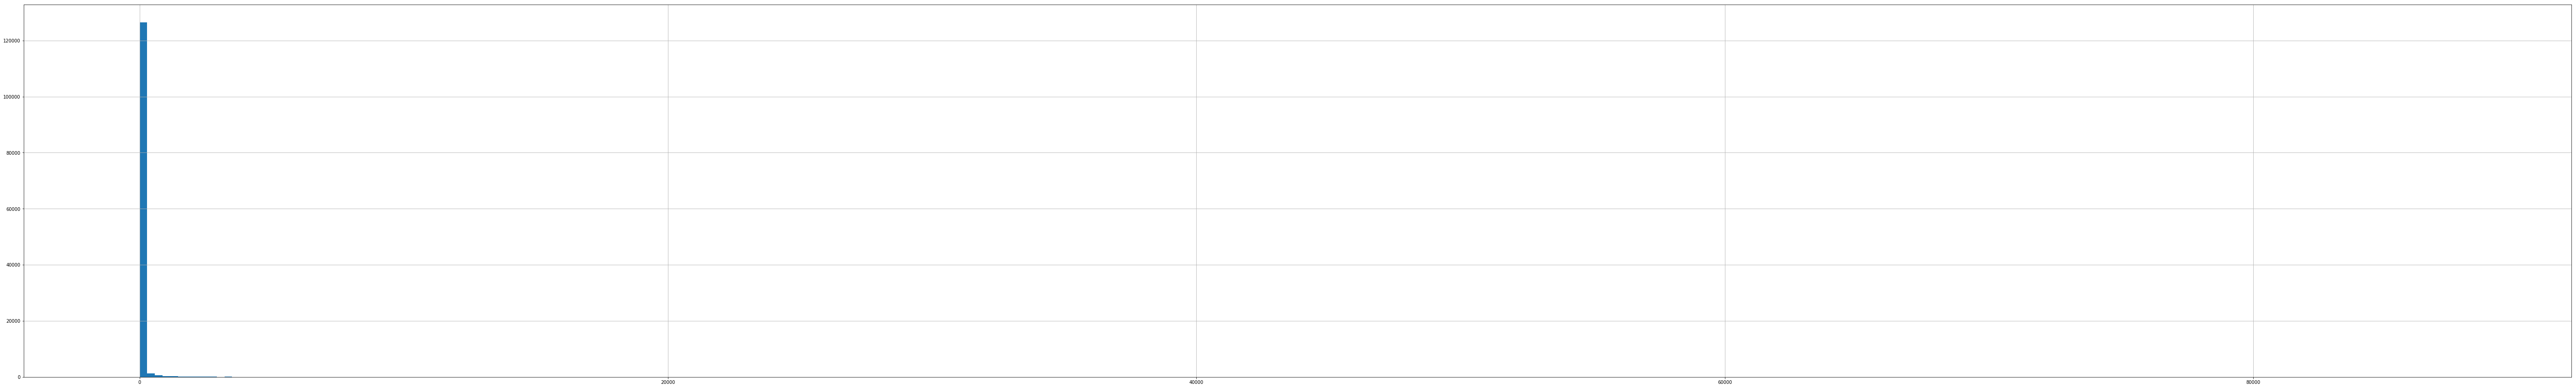

In [29]:
# DOUBLE CLICK the plot below to zoom in
all_words_dict_df['count'].hist(bins=300,figsize=(100,15))

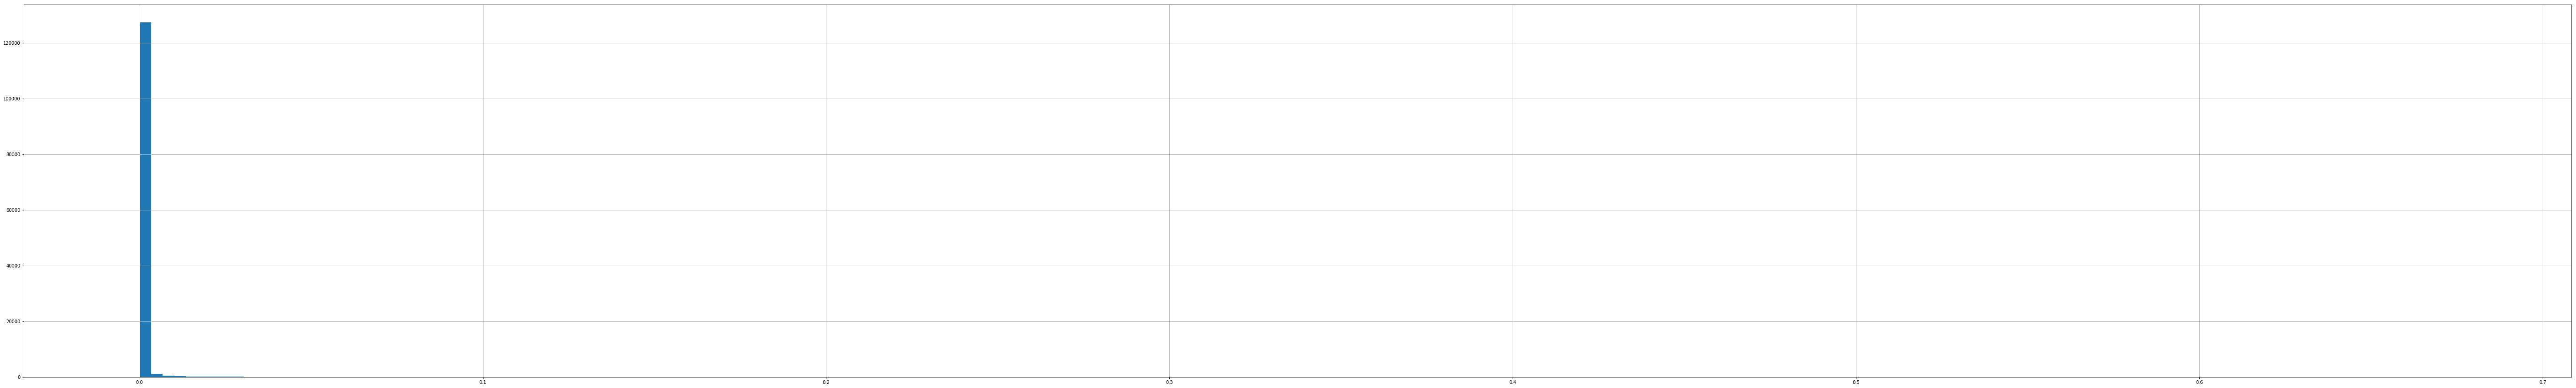

In [27]:
# DOUBLE CLICK the plot below to zoom in
all_words_dict_df['ratio'].hist(bins=300,figsize=(100,15))

### 2.1 assumption is high frequent across all latent topics make it hard to distinguish, thus simply apply more strict keywords filter rule may provide improvement

In [31]:
# traning corpus
train_content_clean  = train_df_sample['content_clean'].tolist()

In [32]:
# test corpus
test_content_clean  = test_df_sample['content_clean'].tolist()

In [33]:
# build dictionary
dictionary = corpora.Dictionary(train_content_clean)
# More strict rule applied here : if keyword show up over 10% of the document, then we remove it
dictionary.filter_extremes(no_below=5, no_above=0.1)
doc_term_matrix_train = [dictionary.doc2bow(doc) for doc in train_content_clean]
Lda = models.ldamodel.LdaModel
np.random.seed(1)
ldamodel = Lda(doc_term_matrix_train, num_topics=15, id2word = dictionary, passes=10)

In [34]:
len(dictionary)

32998

In [35]:
coherence_train = CoherenceModel(model=ldamodel, corpus= doc_term_matrix_train, dictionary=dictionary, coherence='u_mass')
perplexity_train = ldamodel.log_perplexity(doc_term_matrix_train)

In [36]:
print('train set coherence score: %2f  train set perplexity score : %2f'% (coherence_train.get_coherence(), perplexity_train))

train set coherence score: -2.063224  train set perplexity score : -8.951019


In [37]:
doc_term_matrix_test = [dictionary.doc2bow(doc) for doc in test_content_clean]
coherence_test = CoherenceModel(model=ldamodel, corpus= doc_term_matrix_test, dictionary=dictionary, coherence='u_mass')
perplexity_test = ldamodel.log_perplexity(doc_term_matrix_test)

In [38]:
print('test set coherence score: %2f  test set perplexity score : %2f'% (coherence_test.get_coherence(), perplexity_test)) 

test set coherence score: -2.113024  test set perplexity score : -9.219195


In [68]:
print('Top 15 keywrods for topics: \n')
print(ldamodel.print_topics(num_topics=15, num_words=15))

Top 15 keywrods for topics: 

[(0, '0.023*"gas" + 0.016*"coal" + 0.014*"electricity" + 0.012*"plant" + 0.010*"climate" + 0.009*"solar" + 0.008*"emission" + 0.008*"renewable" + 0.007*"target" + 0.007*"fire" + 0.006*"clean" + 0.006*"station" + 0.006*"oil" + 0.006*"wind" + 0.006*"production"'), (1, '0.012*"drug" + 0.011*"disease" + 0.007*"study" + 0.006*"treatment" + 0.006*"drink" + 0.006*"medicine" + 0.006*"dr" + 0.005*"test" + 0.005*"g" + 0.005*"blood" + 0.005*"eat" + 0.005*"sugar" + 0.005*"flu" + 0.004*"heart" + 0.004*"egg"'), (2, '0.023*"police" + 0.011*"man" + 0.011*"court" + 0.009*"officer" + 0.008*"charge" + 0.007*"fire" + 0.006*"crime" + 0.006*"attack" + 0.005*"incident" + 0.005*"investigation" + 0.005*"allege" + 0.004*"arrest" + 0.004*"drug" + 0.004*"kill" + 0.004*"safety"'), (3, '0.014*"club" + 0.011*"sport" + 0.010*"player" + 0.009*"season" + 0.009*"final" + 0.006*"league" + 0.006*"match" + 0.005*"coach" + 0.005*"cup" + 0.005*"star" + 0.004*"stadium" + 0.004*"rugby" + 0.004*"ro

In [71]:
import pyLDAvis
import pyLDAvis.gensim

In [72]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel,doc_term_matrix_train,dictionary)

/Users/mz/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [73]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.080708  0.048884       1        1  10.055122
4      0.225116  0.010945       2        1   8.904814
6     -0.114205  0.188675       3        1   8.815050
9     -0.152077 -0.091906       4        1   8.273630
7     -0.087744 -0.086655       5        1   7.797992
10    -0.025576 -0.036442       6        1   7.053158
5     -0.093062  0.086951       7        1   6.563215
12    -0.095454 -0.011683       8        1   6.487780
3      0.207032  0.061271       9        1   6.412068
2      0.048260  0.195069      10        1   5.725940
14    -0.123521  0.138118      11        1   5.406074
0     -0.140927 -0.130256      12        1   4.778965
8      0.086597 -0.213551      13        1   4.773553
1     -0.047413 -0.113445      14        1   4.593262
13     0.232265 -0.045976      15        1   4.359366, topic_info=      Category         Freq          Term        Total  loglift  logprob
1296   Default  6470.000000          race  6470.000000  30.0000  30.0000
365    Default  9557.000000             p  9557.000000  29.0000  29.0000
211    Default  5987.000000        police  5987.000000  28.0000  28.0000
2690   Default  4977.000000           gas  4977.000000  27.0000  27.0000
2956   Default  8282.000000            pm  8282.000000  26.0000  26.0000
119    Default  5127.000000          care  5127.000000  25.0000  25.0000
345    Default  5147.000000         labor  5147.000000  24.0000  24.0000
99     Default  6974.000000         woman  6974.000000  23.0000  23.0000
3537   Default  5679.000000          club  5679.000000  22.0000  22.0000
171    Default  4844.000000      hospital  4844.000000  21.0000  21.0000
394    Default  4605.000000       student  4605.000000  20.0000  20.0000
2676   Default  3948.000000          coal  3948.000000  19.0000  19.0000
21     Default  5329.000000         court  5329.000000  18.0000  18.0000
1300   Default  4249.000000       vehicle  4249.000000  17.0000  17.0000
1084   Default  4283.000000          vote  4283.000000  16.0000  16.0000
1926   Default  5583.000000      property  5583.000000  15.0000  15.0000
4625   Default  3026.000000   electricity  3026.000000  14.0000  14.0000
206    Default  3719.000000       patient  3719.000000  13.0000  13.0000
2075   Default  4296.000000      investor  4296.000000  12.0000  12.0000
921    Default  3661.000000      marriage  3661.000000  11.0000  11.0000
1400   Default  4697.000000         sport  4697.000000  10.0000  10.0000
118    Default  3435.000000        cancer  3435.000000   9.0000   9.0000
481    Default  3859.000000          drug  3859.000000   8.0000   8.0000
403    Default  4238.000000      turnbull  4238.000000   7.0000   7.0000
3041   Default  4078.000000         china  4078.000000   6.0000   6.0000
1377   Default  3388.000000         plant  3388.000000   5.0000   5.0000
1644   Default  5622.000000         coast  5622.000000   4.0000   4.0000
67     Default  3835.000000        player  3835.000000   3.0000   3.0000
918    Default  4541.000000           man  4541.000000   2.0000   2.0000
192    Default  3285.000000       medical  3285.000000   1.0000   1.0000
...        ...          ...           ...          ...      ...      ...
8018   Topic15   841.375061          bull  1030.995361   2.9296  -5.4466
6111   Topic15   298.482391         whale   321.813171   3.0576  -6.4830
3264   Topic15   879.241455          boat  1141.878052   2.8715  -5.4026
6406   Topic15   808.593811        qantas  1091.477905   2.8329  -5.4864
6340   Topic15   852.996643        cruise  1182.983765   2.8058  -5.4329
3597   Topic15   941.790527          ship  1452.578857   2.6995  -5.3339
1796   Topic15   660.753113         ocean   928.230469   2.7929  -5.6883
1023   Topic15   922.397888           sea  1562.092651   2.6060  -5.3547
2750   Topic15   627.876160  championship   974.227417   2.6935  -5.7393
4844   Topic15   471.823029         shark   64

### Comparison:  
#### This is the previous LDA model which have not remove high frequent common words, as can be seen, these words do bring many noises to distinguish the topics
<img src="ldavis_with_common_kw.jpg">

## 3 conclusion
### 3.1 Honestly, this is my first time to use LDA model and it is not a perfect solution yet, when I print out the topic keywords Yesterday, I immediately realized that many high frequency common keywords bring noise to distinguish topics, however, as it takes some time to train the model on my machine and I thought it was the time limit, so I submit it. 
### 3.2 Today, what I mainly done today is get rid of some common words, i.e., remove words if it occur over 10% of the document - I have not well prove it, the reason I set this parameter is more than 95% keywrods occurred less than 250 times, so this is just my best guess.  Probably I will still keep fine tune it as one of my improvement direction.
### 3.3 At last, I found a tool pyldavis (I know you guys must already very familiar with it) to make very fancy plot of your LDA model, also left plot above can be used as a reference of how good of your LDA model is. My interpretation is that this model can be used as  a reasonable solid baseline model, as all the topic are clearly distant from each other(though still some overlap among some, but not too much). 
### 3.4 I really have had a lot of fun to take this assessment and learn new things, thanks for providing me this chance and allow me to provide further experiment.